# Assignment 3: Evaluating and extending an RNN based POS tagger

### Extensions, which were used:
 
1. Added the option to use a GRU layer instead of LSTM.
2. Added the option to use a bi-directional RNN layer.
5. Implemented dropout.

### Datasets:
1. Universal Dependencies: Polish
2. Universal Dependencies: English
3. Universal Dependencies: Swedish

## Loading libraries

Importing libraries:

In [2]:
# Our standard imports for maths and basic methodology
import numpy as np
from sklearn.model_selection import train_test_split

# For user feedback
from tqdm import tqdm
import matplotlib.pyplot as plt

# Imports for pytorch
import torch
import torch.nn as nn

Let's see if we have a GPU.

In [3]:
if torch.cuda.is_available():
  for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))
else:
  print("No GPU available")

Tesla T4


Downloading the data from github and unzipping it.

In [ ]:
#Downloading the UD datasets from github
!wget -O 'English' https://github.com/UniversalDependencies/UD_English-ParTUT/archive/refs/heads/master.zip
!wget -O 'Polish' https://github.com/UniversalDependencies/UD_Polish-PDB/archive/refs/heads/master.zip 
!wget -O 'Swedish' https://github.com/UniversalDependencies/UD_Swedish-LinES/archive/refs/heads/master.zip

In [ ]:
#Unzipping the folders
!unzip 'English'
!unzip 'Polish'
!unzip 'Swedish'

## Polish

### Loading & parsing CONLLU files

Since UD datasets are already split into test and train sets, we can load them separately. 

In [79]:
def load_dataset(file):
    X = []  #words
    Y = []  #labels
    global sents
    sents = []
    
    with open(file, "r") as f:
      if file.endswith(".conllu"):
          sentences = f.read().split("\n\n")
          if sentences[-1] == "":
              sentences = sentences[:-1]
          for sentence in sentences:
              words = []
              tags =  []
              sent = []
              lines = sentence.split("\n")
              for line in lines:
                  if line.startswith("#"):
                      continue
                  line = line.strip().split("\t")

                  word = line[1].lower() 
                  tag = line[3]

                  words.append(word) 
                  tags.append(tag)
                  sent.append((word,tag))

              X.append(words)
              Y.append(tags)
              sents.append(sent)
      else:
          print("The file needs to be .conllu")

    return X, Y


In [87]:
#Load Polish datasets
X_test, y_test = load_dataset('/content/UD_Polish-PDB-master/pl_pdb-ud-test.conllu')
X_train, y_train = load_dataset('/content/UD_Polish-PDB-master/pl_pdb-ud-train.conllu')
 

In [88]:
X = X_train + X_test
y = y_train + y_test

#print(X_test[:5])
#print(y_test[:5])
#print(X_train[:5])
#print(y_train[:5])

assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)
assert len(X_train)+len(X_test) == len(X)

print("The training set includes %i sentences." % len(X_train))
print("The test set includes %i sentences." % len(X_test))


The training set includes 17722 sentences.
The test set includes 2215 sentences.


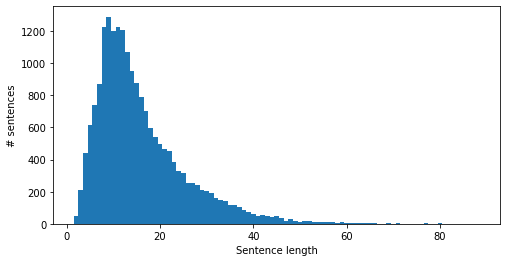

In [89]:
#plotting the length of sentences
l = np.asarray([len(x) for x in X], dtype=np.int)
plt.figure(figsize=(8, 4))
x = np.unique(l)
plt.bar(x, [np.sum(l==e) for e in x], width=1)
plt.xlabel("Sentence length")
plt.ylabel("# sentences")
plt.show()

### Idx2tags & Tag2idx



In [90]:
tokens = {token for sentence in X_train for token in sentence}
idx2token = list(tokens)
idx2token.insert(0, '<UNK>')   #unknown token; unknown class
idx2token.append('<PAD>')  #sentences have different lengths, all columns have different rows
token2idx = {token:idx for idx, token in enumerate(idx2token)}

tags = {tag for tags in y_train for tag in tags}
idx2tag = list(tags)
idx2tag.append('<PAD>')
tag2idx = {tag:idx for idx, tag in enumerate(idx2tag)}

print(idx2token[:30])
print(idx2tag)

['<UNK>', 'prokop', 'oszczędny', 'strzeli', 'trunku', 'kpn', 'poznikały', 'portugalscy', 'uwielbiającym', 'najpiękniejszych', 'uzależnieniem', 'prysło', '7152', 'zaopatrzenie', 'andrzejkowych', 'stoiska', 'ogrodzeniu', 'apator-a', 'płakałyśmy', 'kornhausera', 'ziemską', 'pasek', 'antybiotykami', 'utylizacji', 'koca', 'krótkometrażowym', 'pereł', 'modiglianiego', 'małpę', 'szkodliwych']
['ADV', 'VERB', 'PUNCT', 'DET', 'CCONJ', 'PROPN', 'NOUN', 'NUM', 'ADP', '_', 'SYM', 'PRON', 'SCONJ', 'INTJ', 'PART', 'X', 'ADJ', 'AUX', '<PAD>']


### RNN Model

In [14]:
class Tagger(nn.Module):
  def __init__(self, model_type, word_embedding_dim, hidden_dim, vocabulary_size, tagset_size, bidirectional=False, dropout=0.00, epochs=5):
    super(Tagger, self).__init__()    
                                          
    self.hidden_dim_ = hidden_dim                                     
    self.vocabulary_size_ = vocabulary_size
    self.tagset_size_ = tagset_size
    self.model_type = model_type                                                #Choice between LSTM/GRU
    self.bidirectional = bidirectional                                          #Specifies if bidirectional, False as default
    self.dropout = dropout                                                      #Specifies dropout, 0 as default
    self.epochs = epochs                                                        #Specifies the number of epochs, 5 as default

    self._word_embedding = nn.Embedding(num_embeddings=vocabulary_size,         # Creates the vector space for the input words
                                         embedding_dim=word_embedding_dim, 
                                         padding_idx=token2idx['<PAD>'])
    
    if model_type == 'GRU':
      self._gru = nn.GRU(input_size=word_embedding_dim,                         # The GRU takes an embedded sentence as input, and outputs 
                          hidden_size=hidden_dim,                               # vectors with dimensionality gru_hidden_dim.
                          batch_first=True,
                        bidirectional=bidirectional,
                        dropout=dropout)
    elif model_type == 'LSTM':
      self._lstm = nn.LSTM(input_size=word_embedding_dim,                       # The LSTM takes an embedded sentence as input, and outputs 
                         hidden_size=hidden_dim,                                # vectors with dimensionality lstm_hidden_dim.
                         batch_first=True,
                         bidirectional=bidirectional,
                         dropout=dropout)
    else:
      print("Model not available")                                              #printing error message if model type not LSTM/GRU

    #connected layer
    if bidirectional:
      self._fc = nn.Linear(hidden_dim*2, tagset_size)                           # doubled hidden dimensions if bidirectional
    else:
      self._fc = nn.Linear(hidden_dim, tagset_size)                             # The linear layer maps from the RNN output space to tag space

    self._softmax = nn.LogSoftmax(dim=1)                                        # Softmax of outputting PDFs over tags
    
    self.training_loss_ = list()                                                # For plotting
    self.training_accuracy_ = list()

    if torch.cuda.is_available():                                               # Move the model to the GPU (if we have one)
      self.cuda()


  def pad_and_encode(self, sentences, labels):
    assert len(sentences)==len(labels)
    assert np.all([len(sentence)==len(tags) for sentence, tags in zip(sentences, labels)])
    max_sentence_length = np.max([len(sentence) for sentence in sentences])     # Find out how much to pad
    padded_sentences = torch.zeros(len(sentences), max_sentence_length,         # Create data structures with <PAD> as default
                                  dtype=torch.long)
    padded_sentences[:] = token2idx['<PAD>']
    padded_labels = torch.zeros(len(sentences), max_sentence_length, 
                                dtype=torch.long)
    padded_labels[:] = tag2idx['<PAD>']
    for i, (sentence, tags) in enumerate(zip(sentences, labels)):               # Loop over the data
      for j, token in enumerate(sentence):
        if token in token2idx.keys():
          padded_sentences[i, j] = token2idx[token]
        else:
          padded_sentences[i, j] = token2idx['<UNK>']
      for j, tag in enumerate(tags):
        padded_labels[i, j] = tag2idx[tag]
    return padded_sentences, padded_labels


  def batch_iterator(self, sentences, labels, batch_size=64):
    """Helper function for iterating over batches of the data"""
    assert len(sentences) == len(labels)
    for i in range(0, len(sentences), batch_size):
      X, y = self.pad_and_encode(sentences[i:min(i+batch_size, len(sentences))], 
                              labels[i:min(i+batch_size, len(sentences))])
      if torch.cuda.is_available():                                             # Move data to the GPU, if possible, before yielding it
        yield (X.cuda(), y.cuda())
      else:
        yield (X, y)


  def forward(self, padded_sentences):
     """The forward pass through the network"""

     batch_size, max_sentence_length = padded_sentences.size()

     embedded_sentences = self._word_embedding(padded_sentences)                 # Sentences encoded as integers are mapped to vectors    

     sentence_lengths = (padded_sentences!=token2idx['<PAD>']).sum(dim=1)        # Find the length of sentences
     sentence_lengths = sentence_lengths.long().cpu()                            # Ensure the correct format
     X = nn.utils.rnn.pack_padded_sequence(embedded_sentences, sentence_lengths, # Pack the embedded data
                                            batch_first=True, enforce_sorted=False)
     if self.model_type == 'GRU':
       gru_out, _ = self._gru(X)                                                   # Run the GRU layer
       X, _ = nn.utils.rnn.pad_packed_sequence(gru_out, batch_first=True)          # Unpack the output from the GRU

     elif self.model_type == 'LSTM': 
       lstm_out, _ = self._lstm(X)                                               # Run the LSTM layer
       X, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)         # Unpack the output from the LSTM


     X = X.contiguous().view(-1, X.shape[2])                                     # The output from the LSTM/GRU layer is flattened
     tag_space = self._fc(X)                                                     # Fully connected layer
     tag_scores = self._softmax(tag_space)                                       # Softmax is applied to normalise the outputs

     return tag_scores.view(batch_size, max_sentence_length, self.tagset_size_)


  def fit(self, X, y):
    loss_function = nn.NLLLoss(ignore_index=tag2idx['<PAD>'])                   # A loss function that fits our choice of output layer and data.
                                                                                # loss function will ignore the padding index in the targets.
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)                   # We give the optimiser the parameters to work with, note that we can choose to only give some parameters

    batch_size = 256                                                            # Define the size of each batch
    for epoch in range(self.epochs):                                            # Times to loop over the full dataset
      with tqdm(self.batch_iterator(X_train, y_train, batch_size), 
           total=len(X_train)//batch_size+1, unit="batch", desc="Epoch %i" % epoch) as batches:
        for inputs, targets in batches:                                         # Loop once over the training data
          model.zero_grad()                                                     # Reset gradients
          scores = model(inputs)                                                # Forward pass
          loss = loss_function(scores.view(-1, model.tagset_size_),             # Get loss, the data is reshaped as a long line of predictions and targets
                              targets.view(-1))               
          loss.backward()                                                       # Backpropagate the error
          optimizer.step()                                                      # Run the optimizer to change the weights w.r.t the loss
          predictions = scores.argmax(dim=2, keepdim=True).squeeze()            # Calculate the batch training accuracy
          mask = targets!=tag2idx['<PAD>']                                      # Create a mask for ignoring <PAD> in the targets
          correct = (predictions[mask] == targets[mask]).sum().item()           # Item pulls the value from the GPU automatically (if needed)
          accuracy = correct / mask.sum().item()*100
          model.training_accuracy_.append(accuracy)                             # Save the accuracy for plotting
          model.training_loss_.append(loss.item())                              # Save the loss for plotting
          batches.set_postfix(loss=loss.item(), accuracy=accuracy)              # Update the progress bar
  
  def plot(self):
    batch_size = 256
    fig = plt.figure(figsize=(6, 4))
    ax = plt.subplot()
    ax.set_title("Plot for the (hopefully) decreasing loss over epochs")
    ax.plot(model.training_loss_, 'b-')
    ax.set_ylabel("Training Loss", color='b')
    ax.set_xlabel("Epoch")
    # ax.set_yscale('log')
    ax.tick_params(axis='y', labelcolor='b')
    ax = ax.twinx()
    ax.plot(model.training_accuracy_, 'r-')
    ax.set_ylabel("Accuracy [%]", color='r')
    ax.tick_params(axis='y', labelcolor='r')
    a = list(ax.axis())
    a[2] = 0
    a[3] = 100
    ax.axis(a)
    t = np.arange(0, len(model.training_accuracy_), len(X_train)//batch_size+1)
    ax.set_xticks(ticks=t)
    ax.set_xticklabels(labels=np.arange(len(t)))
    fig.tight_layout()
    plt.show()
  
  def predict(self, X, y):  
    batch_size = 256
    pred = []
    with torch.no_grad():                                                       
      for inputs, targets in self.batch_iterator(X, y, batch_size=batch_size):  # Loop once over the test data
        scores = model(inputs)                                                  # Runs the test data through the model
        predictions = scores.argmax(dim=2, keepdim=True).squeeze() 
        mask = targets!=tag2idx['<PAD>']                                        
        pred.append(predictions)  
      return pred

  def score(self, X, y):
    batch_size = 256
    with torch.no_grad():                                                       
      n_correct = 0
      n_total = 0
      for inputs, targets in self.batch_iterator(X, y, batch_size=batch_size):  # Loop once over the test data
        scores = model(inputs)                                                  # Runs the test data through the model
        predictions = scores.argmax(dim=2, keepdim=True).squeeze()              # Finds the predictions
        mask = targets!=tag2idx['<PAD>']                                        # Create a mask for ignoring <PAD> in the targets; MASK = non_pad_elements
        n_correct += (predictions[mask] == targets[mask]).sum().item()          # Sums the number of correct predictions
        n_total += mask.sum().item()
    return 100*n_correct/n_total
    #print("Test accuracy %.1f%%" % (100*n_correct/n_total))

### Tuning hyperparameters
Looking for the best model.

In [ ]:
import warnings

#Hyperparameters
model_types = ['LSTM', 'GRU']
bidirectional_values= [False, True]
dropout_values = [0.0, 0.01, 0.001]
dimensions = [32, 64, 96, 128]
hid_dimensions = [32, 64, 96, 128]

#dataframe
results = []

for model_type in model_types:
  for dim in dimensions:
    for h_dim in hid_dimensions:
      for bidir in bidirectional_values:
        for drop in dropout_values:
            with warnings.catch_warnings():
              warnings.simplefilter("ignore")
              print(f'Training with hyperparameters: model_type [{model_type}], hidden_dim [{h_dim}], word_embedding_dim [{dim}], bidirectional [{bidir}], dropout [{drop}]')
              model = Tagger(model_type = model_type,
                      word_embedding_dim=dim, #32,                                        
                      hidden_dim=h_dim, #64,                                          
                      vocabulary_size=len(token2idx),                              
                      tagset_size=len(tag2idx)-1,                                  
                      bidirectional=bidir,
                      dropout=drop)   
              
              model.fit(X_train, y_train)

              model.predict(X_test, y_test)

              acc = model.score(X_test, y_test)

              #dataframe
              results.append({
                    'model': model_type,
                    'hidden_dim': h_dim,
                    'word_embedding_dim': dim,
                    'bidirectional': bidir,
                    'dropout': drop,
                    'Accuracy': acc
                      })

In [ ]:
import pandas as pd
results = pd.DataFrame(results)
results = results.sort_values(by='Accuracy', ascending=False)
print(results)

### Final model

In [104]:
model = Tagger(model_type = "LSTM",
               word_embedding_dim=96,                                     
               hidden_dim=64,                                           
               vocabulary_size=len(token2idx),                              
               tagset_size=len(tag2idx)-1,                                  
               bidirectional=True,
               dropout=0.010)   

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.01 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [95]:
model.fit(X_train, y_train)
model.score(X_test, y_test)

Epoch 4: 100%|██████████| 70/70 [00:03<00:00, 18.67batch/s, accuracy=100, loss=0.00878]


91.08867038710248

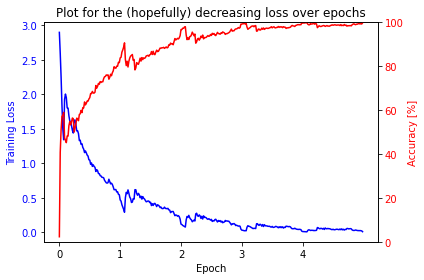

In [37]:
model.plot()

### Baseline model

As a Baseline model, I decided to use the most Vanilla LTSM, which was implemented in the beginning.

In [45]:
model = Tagger(model_type = "LSTM",
               word_embedding_dim=32,
               hidden_dim=64, 
               vocabulary_size=len(token2idx),                             
               tagset_size=len(tag2idx)-1)   

Epoch 4: 100%|██████████| 70/70 [00:03<00:00, 21.84batch/s, accuracy=97.8, loss=0.0736]




====
Accuracy for the Baseline model is 87.56311453627426
====




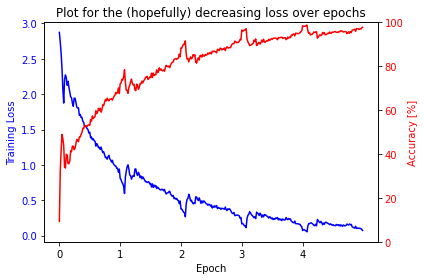

In [46]:
# training
model.fit(X_train, y_train)

#score
score = model.score(X_test, y_test)
print('\n')
print('====')
print(f'Accuracy for the Baseline model is {score}')
print('====')
print('\n')

#plot
model.plot()

## English

### Loading & parsing CONLLU files

Since UD datasets are already split into test and train sets, we can load them separately. 

In [107]:
def load_conllu(file):
    X = []  #words
    Y = []  #labels
    global sents
    sents = []
    
    with open(file, "r") as f:
      if file.endswith(".conllu"):
          sentences = f.read().split("\n\n")
          if sentences[-1] == "":
              sentences = sentences[:-1]
          for sentence in sentences:
              words = []
              tags =  []
              sent = []
              lines = sentence.split("\n")
              for line in lines:
                  if line.startswith("#"):
                      continue
                  line = line.strip().split("\t")

                  word = line[1].lower() 
                  tag = line[3]

                  words.append(word) 
                  tags.append(tag)
                  sent.append((word,tag))

              X.append(words)
              Y.append(tags)
              sents.append(sent)
      else:
          print("The file needs to be .conllu")

    return X, Y


In [108]:
# Load English datasets
X_test, y_test = load_conllu('/content/UD_English-ParTUT-master/en_partut-ud-test.conllu')
X_train, y_train = load_conllu('/content/UD_English-ParTUT-master/en_partut-ud-train.conllu')

In [109]:
X = X_train + X_test
y = y_train + y_test

assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)
assert len(X_train)+len(X_test) == len(X)

print("The training set includes %i sentences." % len(X_train))
print("The test set includes %i sentences." % len(X_test))


The training set includes 1781 sentences.
The test set includes 153 sentences.


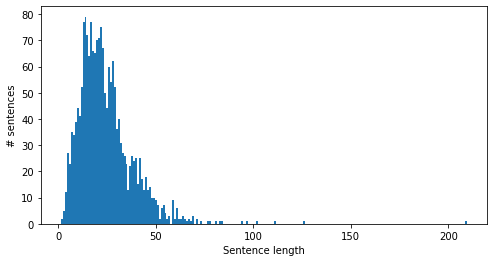

In [110]:
#plotting the length of sentences
l = np.asarray([len(x) for x in X], dtype=np.int)
plt.figure(figsize=(8, 4))
x = np.unique(l)
plt.bar(x, [np.sum(l==e) for e in x], width=1)
plt.xlabel("Sentence length")
plt.ylabel("# sentences")
plt.show()

### Idx2tags & Tag2idx



In [111]:
tokens = {token for sentence in X_train for token in sentence}
idx2token = list(tokens)
idx2token.insert(0, '<UNK>')   #unknown token; unknown class
idx2token.append('<PAD>')  #sentences have different lengths, all columns have different rows
token2idx = {token:idx for idx, token in enumerate(idx2token)}

tags = {tag for tags in y_train for tag in tags}
idx2tag = list(tags)
idx2tag.append('<PAD>')
tag2idx = {tag:idx for idx, tag in enumerate(idx2tag)}

print(idx2token[:30])
print(idx2tag)

['<UNK>', 'ordered', 'memorials', '1799', 'target', 'awful', 'hye', 'examined', 'closer', 'generalization', ')', '22', 'golden', 'tabled', 'obliged', 'laments', 'educated', 'observed', 'databases', '30', 'demonstrate', 'previous', 'morality', 'sense', 'praised', 'pious', '1878', 'ratings', 'governance', 'succeed']
['ADV', 'DET', 'VERB', 'PUNCT', 'PROPN', 'CCONJ', 'NOUN', 'NUM', 'ADP', '_', 'SYM', 'PRON', 'SCONJ', 'INTJ', 'PART', 'X', 'ADJ', 'AUX', '<PAD>']


### RNN Model

In [112]:
class Tagger(nn.Module):
  def __init__(self, model_type, word_embedding_dim, hidden_dim, vocabulary_size, tagset_size, bidirectional=False, dropout=0.00, epochs=5):
    super(Tagger, self).__init__()    
                                          
    self.hidden_dim_ = hidden_dim                                     
    self.vocabulary_size_ = vocabulary_size
    self.tagset_size_ = tagset_size
    self.model_type = model_type                                                #Choice between LSTM/GRU
    self.bidirectional = bidirectional                                          #Specifies if bidirectional, False as default
    self.dropout = dropout                                                      #Specifies dropout, 0 as default
    self.epochs = epochs                                                        #Specifies the number of epochs, 5 as default

    self._word_embedding = nn.Embedding(num_embeddings=vocabulary_size,         # Creates the vector space for the input words
                                         embedding_dim=word_embedding_dim, 
                                         padding_idx=token2idx['<PAD>'])
    
    if model_type == 'GRU':
      self._gru = nn.GRU(input_size=word_embedding_dim,                         # The GRU takes an embedded sentence as input, and outputs 
                          hidden_size=hidden_dim,                               # vectors with dimensionality gru_hidden_dim.
                          batch_first=True,
                        bidirectional=bidirectional,
                        dropout=dropout)
    elif model_type == 'LSTM':
      self._lstm = nn.LSTM(input_size=word_embedding_dim,                       # The LSTM takes an embedded sentence as input, and outputs 
                         hidden_size=hidden_dim,                                # vectors with dimensionality lstm_hidden_dim.
                         batch_first=True,
                         bidirectional=bidirectional,
                         dropout=dropout)
    else:
      print("Model not available")                                              #printing error message if model type not LSTM/GRU

    #connected layer
    if bidirectional:
      self._fc = nn.Linear(hidden_dim*2, tagset_size)                           # doubled hidden dimensions if bidirectional
    else:
      self._fc = nn.Linear(hidden_dim, tagset_size)                             # The linear layer maps from the RNN output space to tag space

    self._softmax = nn.LogSoftmax(dim=1)                                        # Softmax of outputting PDFs over tags
    
    self.training_loss_ = list()                                                # For plotting
    self.training_accuracy_ = list()

    if torch.cuda.is_available():                                               # Move the model to the GPU (if we have one)
      self.cuda()


  def pad_and_encode(self, sentences, labels):
    assert len(sentences)==len(labels)
    assert np.all([len(sentence)==len(tags) for sentence, tags in zip(sentences, labels)])
    max_sentence_length = np.max([len(sentence) for sentence in sentences])     # Find out how much to pad
    padded_sentences = torch.zeros(len(sentences), max_sentence_length,         # Create data structures with <PAD> as default
                                  dtype=torch.long)
    padded_sentences[:] = token2idx['<PAD>']
    padded_labels = torch.zeros(len(sentences), max_sentence_length, 
                                dtype=torch.long)
    padded_labels[:] = tag2idx['<PAD>']
    for i, (sentence, tags) in enumerate(zip(sentences, labels)):               # Loop over the data
      for j, token in enumerate(sentence):
        if token in token2idx.keys():
          padded_sentences[i, j] = token2idx[token]
        else:
          padded_sentences[i, j] = token2idx['<UNK>']
      for j, tag in enumerate(tags):
        padded_labels[i, j] = tag2idx[tag]
    return padded_sentences, padded_labels


  def batch_iterator(self, sentences, labels, batch_size=64):
    """Helper function for iterating over batches of the data"""
    assert len(sentences) == len(labels)
    for i in range(0, len(sentences), batch_size):
      X, y = self.pad_and_encode(sentences[i:min(i+batch_size, len(sentences))], 
                              labels[i:min(i+batch_size, len(sentences))])
      if torch.cuda.is_available():                                             # Move data to the GPU, if possible, before yielding it
        yield (X.cuda(), y.cuda())
      else:
        yield (X, y)


  def forward(self, padded_sentences):
     """The forward pass through the network"""

     batch_size, max_sentence_length = padded_sentences.size()

     embedded_sentences = self._word_embedding(padded_sentences)                 # Sentences encoded as integers are mapped to vectors    

     sentence_lengths = (padded_sentences!=token2idx['<PAD>']).sum(dim=1)        # Find the length of sentences
     sentence_lengths = sentence_lengths.long().cpu()                            # Ensure the correct format
     X = nn.utils.rnn.pack_padded_sequence(embedded_sentences, sentence_lengths, # Pack the embedded data
                                            batch_first=True, enforce_sorted=False)
     if self.model_type == 'GRU':
       gru_out, _ = self._gru(X)                                                   # Run the GRU layer
       X, _ = nn.utils.rnn.pad_packed_sequence(gru_out, batch_first=True)          # Unpack the output from the GRU

     elif self.model_type == 'LSTM': 
       lstm_out, _ = self._lstm(X)                                               # Run the LSTM layer
       X, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)         # Unpack the output from the LSTM


     X = X.contiguous().view(-1, X.shape[2])                                     # The output from the LSTM/GRU layer is flattened
     tag_space = self._fc(X)                                                     # Fully connected layer
     tag_scores = self._softmax(tag_space)                                       # Softmax is applied to normalise the outputs

     return tag_scores.view(batch_size, max_sentence_length, self.tagset_size_)


  def fit(self, X, y):
    loss_function = nn.NLLLoss(ignore_index=tag2idx['<PAD>'])                   # A loss function that fits our choice of output layer and data.
                                                                                # loss function will ignore the padding index in the targets.
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)                   # We give the optimiser the parameters to work with, note that we can choose to only give some parameters

    batch_size = 256                                                            # Define the size of each batch
    for epoch in range(self.epochs):                                            # Times to loop over the full dataset
      with tqdm(self.batch_iterator(X_train, y_train, batch_size), 
           total=len(X_train)//batch_size+1, unit="batch", desc="Epoch %i" % epoch) as batches:
        for inputs, targets in batches:                                         # Loop once over the training data
          model.zero_grad()                                                     # Reset gradients
          scores = model(inputs)                                                # Forward pass
          loss = loss_function(scores.view(-1, model.tagset_size_),             # Get loss, the data is reshaped as a long line of predictions and targets
                              targets.view(-1))               
          loss.backward()                                                       # Backpropagate the error
          optimizer.step()                                                      # Run the optimizer to change the weights w.r.t the loss
          predictions = scores.argmax(dim=2, keepdim=True).squeeze()            # Calculate the batch training accuracy
          mask = targets!=tag2idx['<PAD>']                                      # Create a mask for ignoring <PAD> in the targets
          correct = (predictions[mask] == targets[mask]).sum().item()           # Item pulls the value from the GPU automatically (if needed)
          accuracy = correct / mask.sum().item()*100
          model.training_accuracy_.append(accuracy)                             # Save the accuracy for plotting
          model.training_loss_.append(loss.item())                              # Save the loss for plotting
          batches.set_postfix(loss=loss.item(), accuracy=accuracy)              # Update the progress bar
  
  def plot(self):
    batch_size = 256
    fig = plt.figure(figsize=(6, 4))
    ax = plt.subplot()
    ax.set_title("Plot for the (hopefully) decreasing loss over epochs")
    ax.plot(model.training_loss_, 'b-')
    ax.set_ylabel("Training Loss", color='b')
    ax.set_xlabel("Epoch")
    # ax.set_yscale('log')
    ax.tick_params(axis='y', labelcolor='b')
    ax = ax.twinx()
    ax.plot(model.training_accuracy_, 'r-')
    ax.set_ylabel("Accuracy [%]", color='r')
    ax.tick_params(axis='y', labelcolor='r')
    a = list(ax.axis())
    a[2] = 0
    a[3] = 100
    ax.axis(a)
    t = np.arange(0, len(model.training_accuracy_), len(X_train)//batch_size+1)
    ax.set_xticks(ticks=t)
    ax.set_xticklabels(labels=np.arange(len(t)))
    fig.tight_layout()
    plt.show()
  
  def predict(self, X, y):  
    batch_size = 256
    pred = []
    with torch.no_grad():                                                       
      for inputs, targets in self.batch_iterator(X, y, batch_size=batch_size):  # Loop once over the test data
        scores = model(inputs)                                                  # Runs the test data through the model
        predictions = scores.argmax(dim=2, keepdim=True).squeeze() 
        mask = targets!=tag2idx['<PAD>']                                        
        pred.append(predictions)  
      return pred

  def score(self, X, y):
    batch_size = 256
    with torch.no_grad():                                                       
      n_correct = 0
      n_total = 0
      for inputs, targets in self.batch_iterator(X, y, batch_size=batch_size):  # Loop once over the test data
        scores = model(inputs)                                                  # Runs the test data through the model
        predictions = scores.argmax(dim=2, keepdim=True).squeeze()              # Finds the predictions
        mask = targets!=tag2idx['<PAD>']                                        # Create a mask for ignoring <PAD> in the targets; MASK = non_pad_elements
        n_correct += (predictions[mask] == targets[mask]).sum().item()          # Sums the number of correct predictions
        n_total += mask.sum().item()
    return 100*n_correct/n_total                                                #accuracy

### Tuning hyperparameters
Looking for the best model.

In [ ]:
import warnings

#Hyperparameters
model_types = ['LSTM', 'GRU']
bidirectional_values= [False, True]
dropout_values = [0.0, 0.01, 0.001]
dimensions = [32, 64, 96, 128]
hid_dimensions = [32, 64, 96, 128]

#dataframe
results = []

for model_type in model_types:
  for dim in dimensions:
    for h_dim in hid_dimensions:
      for bidir in bidirectional_values:
        for drop in dropout_values:
            with warnings.catch_warnings():
              warnings.simplefilter("ignore")
              print(f'Training with hyperparameters: model_type [{model_type}], hidden_dim [{h_dim}], word_embedding_dim [{dim}], bidirectional [{bidir}], dropout [{drop}]')
              model = Tagger(model_type = model_type,
                      word_embedding_dim=dim, #32,                                        
                      hidden_dim=h_dim, #64,                                          
                      vocabulary_size=len(token2idx),                              
                      tagset_size=len(tag2idx)-1,                                  
                      bidirectional=bidir,
                      dropout=drop)   
              
              model.fit(X_train, y_train)

              model.predict(X_test, y_test)

              acc = model.score(X_test, y_test)

              #dataframe
              results.append({
                    'model': model_type,
                    'hidden_dim': h_dim,
                    'word_embedding_dim': dim,
                    'bidirectional': bidir,
                    'dropout': drop,
                    'Accuracy': acc
                      })

In [ ]:
import pandas as pd
eng_results = pd.DataFrame(results)
eng_results = eng_results.sort_values(by='Accuracy', ascending=False)
print(eng_results)

### Final model

In [ ]:
model = Tagger(model_type = "LSTM",
               word_embedding_dim=64,                                        # Dimensionality of the work embedding
               hidden_dim=128,                                           # Dimensionality of the hidden state in the LSTM
               vocabulary_size=len(token2idx),                              # The vocabulary incudes both the 'padding' and 'unknown' symbols
               tagset_size=len(tag2idx)-1,                                  # We have no interest in the network outputting the padding symbol
               bidirectional=True,
               dropout=0.001)   

In [130]:
model.fit(X_train, y_train)
model.score(X_test, y_test)

Epoch 4: 100%|██████████| 7/7 [00:00<00:00, 12.03batch/s, accuracy=83.2, loss=0.518]


85.63892145369284

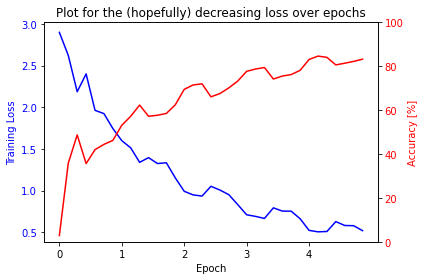

In [132]:
model.plot()

### Baseline model

As a Baseline model, I decided to use the most Vanilla LTSM, which was implemented in the beginning.

In [133]:
model = Tagger(model_type = "LSTM",
               word_embedding_dim=32,
               hidden_dim=64, 
               vocabulary_size=len(token2idx),                             
               tagset_size=len(tag2idx)-1)   

Epoch 4: 100%|██████████| 7/7 [00:00<00:00, 15.61batch/s, accuracy=66.1, loss=1.04]




====
Accuracy for the Baseline model is 72.30363423212192
====




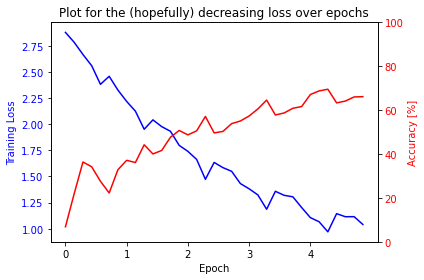

In [134]:
# training
model.fit(X_train, y_train)

#score
score = model.score(X_test, y_test)
print('\n')
print('====')
print(f'Accuracy for the Baseline model is {score}')
print('====')
print('\n')

#plot
model.plot()

## Swedish

### Loading & parsing CONLLU files

In [135]:
def load_conllu(file):
    X = []  #words
    Y = []  #labels
    global sents
    sents = []
    
    with open(file, "r") as f:
      if file.endswith(".conllu"):
          sentences = f.read().split("\n\n")
          if sentences[-1] == "":
              sentences = sentences[:-1]
          for sentence in sentences:
              words = []
              tags =  []
              sent = []
              lines = sentence.split("\n")
              for line in lines:
                  if line.startswith("#"):
                      continue
                  line = line.strip().split("\t")

                  word = line[1].lower() 
                  tag = line[3]

                  words.append(word) 
                  tags.append(tag)
                  sent.append((word,tag))

              X.append(words)
              Y.append(tags)
              sents.append(sent)
      else:
          print("The file needs to be .conllu")

    return X, Y


In [136]:
# Load Swedish datasets
X_test, y_test = load_dataset('/content/UD_Swedish-LinES-master/sv_lines-ud-test.conllu')
X_train, y_train = load_dataset('/content/UD_Swedish-LinES-master/sv_lines-ud-train.conllu')  

In [137]:
X = X_train + X_test
y = y_train + y_test

#print(X_test[:5])
#print(y_test[:5])
#print(X_train[:5])
#print(y_train[:5])

assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)
assert len(X_train)+len(X_test) == len(X)

print("The training set includes %i sentences." % len(X_train))
print("The test set includes %i sentences." % len(X_test))


The training set includes 3176 sentences.
The test set includes 1035 sentences.


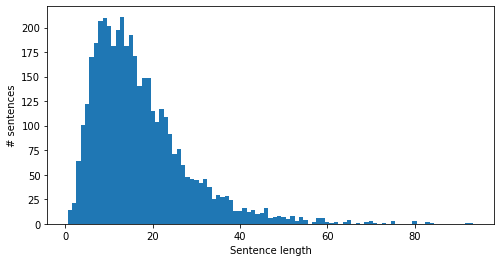

In [138]:
#plotting the length of sentences
l = np.asarray([len(x) for x in X], dtype=np.int)
plt.figure(figsize=(8, 4))
x = np.unique(l)
plt.bar(x, [np.sum(l==e) for e in x], width=1)
plt.xlabel("Sentence length")
plt.ylabel("# sentences")
plt.show()

### Idx2tags & Tag2idx



In [139]:
tokens = {token for sentence in X_train for token in sentence}
idx2token = list(tokens)
idx2token.insert(0, '<UNK>')   #unknown token; unknown class
idx2token.append('<PAD>')  #sentences have different lengths, all columns have different rows
token2idx = {token:idx for idx, token in enumerate(idx2token)}

tags = {tag for tags in y_train for tag in tags}
idx2tag = list(tags)
idx2tag.append('<PAD>')
tag2idx = {tag:idx for idx, tag in enumerate(idx2tag)}

print(idx2token[:30])
print(idx2tag)

['<UNK>', 'verkar', 'kullvräkt', 'percy', 'kvinnfolk', 'läggas', 'njöt', 'höra', 'konstmuseum', 'vraket', 'uppochner', 'tidiga', 'sistnämnda', 'trängdes', 'snegla', 'etapper', 'utrymmet', 'orsak', 'elits', 'snärtar', 'ända', 'kareernas', 'skillnaden', 'bogserarna', ')', 'overkliga', 'tjänsterum', 'bohéme', 'medellängd', 'förfarandet']
['ADV', 'VERB', 'PROPN', 'DET', 'PUNCT', 'CCONJ', 'NOUN', 'NUM', 'ADP', 'SYM', 'PRON', 'SCONJ', 'INTJ', 'PART', 'X', 'ADJ', 'AUX', '<PAD>']


### RNN Model

In [64]:
class Tagger(nn.Module):
  def __init__(self, model_type, word_embedding_dim, hidden_dim, vocabulary_size, tagset_size, bidirectional=False, dropout=0.00, epochs=5):
    super(Tagger, self).__init__()    
                                          
    self.hidden_dim_ = hidden_dim                                     
    self.vocabulary_size_ = vocabulary_size
    self.tagset_size_ = tagset_size
    self.model_type = model_type                                                #Choice between LSTM/GRU
    self.bidirectional = bidirectional                                          #Specifies if bidirectional, False as default
    self.dropout = dropout                                                      #Specifies dropout, 0 as default
    self.epochs = epochs                                                        #Specifies the number of epochs, 5 as default

    self._word_embedding = nn.Embedding(num_embeddings=vocabulary_size,         # Creates the vector space for the input words
                                         embedding_dim=word_embedding_dim, 
                                         padding_idx=token2idx['<PAD>'])
    
    if model_type == 'GRU':
      self._gru = nn.GRU(input_size=word_embedding_dim,                         # The GRU takes an embedded sentence as input, and outputs 
                          hidden_size=hidden_dim,                               # vectors with dimensionality gru_hidden_dim.
                          batch_first=True,
                        bidirectional=bidirectional,
                        dropout=dropout)
    elif model_type == 'LSTM':
      self._lstm = nn.LSTM(input_size=word_embedding_dim,                       # The LSTM takes an embedded sentence as input, and outputs 
                         hidden_size=hidden_dim,                                # vectors with dimensionality lstm_hidden_dim.
                         batch_first=True,
                         bidirectional=bidirectional,
                         dropout=dropout)
    else:
      print("Model not available")                                              #printing error message if model type not LSTM/GRU

    #connected layer
    if bidirectional:
      self._fc = nn.Linear(hidden_dim*2, tagset_size)                           # doubled hidden dimensions if bidirectional
    else:
      self._fc = nn.Linear(hidden_dim, tagset_size)                             # The linear layer maps from the RNN output space to tag space

    self._softmax = nn.LogSoftmax(dim=1)                                        # Softmax of outputting PDFs over tags
    
    self.training_loss_ = list()                                                # For plotting
    self.training_accuracy_ = list()

    if torch.cuda.is_available():                                               # Move the model to the GPU (if we have one)
      self.cuda()


  def pad_and_encode(self, sentences, labels):
    assert len(sentences)==len(labels)
    assert np.all([len(sentence)==len(tags) for sentence, tags in zip(sentences, labels)])
    max_sentence_length = np.max([len(sentence) for sentence in sentences])     # Find out how much to pad
    padded_sentences = torch.zeros(len(sentences), max_sentence_length,         # Create data structures with <PAD> as default
                                  dtype=torch.long)
    padded_sentences[:] = token2idx['<PAD>']
    padded_labels = torch.zeros(len(sentences), max_sentence_length, 
                                dtype=torch.long)
    padded_labels[:] = tag2idx['<PAD>']
    for i, (sentence, tags) in enumerate(zip(sentences, labels)):               # Loop over the data
      for j, token in enumerate(sentence):
        if token in token2idx.keys():
          padded_sentences[i, j] = token2idx[token]
        else:
          padded_sentences[i, j] = token2idx['<UNK>']
      for j, tag in enumerate(tags):
        padded_labels[i, j] = tag2idx[tag]
    return padded_sentences, padded_labels


  def batch_iterator(self, sentences, labels, batch_size=64):
    """Helper function for iterating over batches of the data"""
    assert len(sentences) == len(labels)
    for i in range(0, len(sentences), batch_size):
      X, y = self.pad_and_encode(sentences[i:min(i+batch_size, len(sentences))], 
                              labels[i:min(i+batch_size, len(sentences))])
      if torch.cuda.is_available():                                             # Move data to the GPU, if possible, before yielding it
        yield (X.cuda(), y.cuda())
      else:
        yield (X, y)


  def forward(self, padded_sentences):
     """The forward pass through the network"""

     batch_size, max_sentence_length = padded_sentences.size()

     embedded_sentences = self._word_embedding(padded_sentences)                 # Sentences encoded as integers are mapped to vectors    

     sentence_lengths = (padded_sentences!=token2idx['<PAD>']).sum(dim=1)        # Find the length of sentences
     sentence_lengths = sentence_lengths.long().cpu()                            # Ensure the correct format
     X = nn.utils.rnn.pack_padded_sequence(embedded_sentences, sentence_lengths, # Pack the embedded data
                                            batch_first=True, enforce_sorted=False)
     if self.model_type == 'GRU':
       gru_out, _ = self._gru(X)                                                   # Run the GRU layer
       X, _ = nn.utils.rnn.pad_packed_sequence(gru_out, batch_first=True)          # Unpack the output from the GRU

     elif self.model_type == 'LSTM': 
       lstm_out, _ = self._lstm(X)                                               # Run the LSTM layer
       X, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)         # Unpack the output from the LSTM


     X = X.contiguous().view(-1, X.shape[2])                                     # The output from the LSTM/GRU layer is flattened
     tag_space = self._fc(X)                                                     # Fully connected layer
     tag_scores = self._softmax(tag_space)                                       # Softmax is applied to normalise the outputs

     return tag_scores.view(batch_size, max_sentence_length, self.tagset_size_)


  def fit(self, X, y):
    loss_function = nn.NLLLoss(ignore_index=tag2idx['<PAD>'])                   # A loss function that fits our choice of output layer and data.
                                                                                # loss function will ignore the padding index in the targets.
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)                   # We give the optimiser the parameters to work with, note that we can choose to only give some parameters

    batch_size = 256                                                            # Define the size of each batch
    for epoch in range(self.epochs):                                            # Times to loop over the full dataset
      with tqdm(self.batch_iterator(X_train, y_train, batch_size), 
           total=len(X_train)//batch_size+1, unit="batch", desc="Epoch %i" % epoch) as batches:
        for inputs, targets in batches:                                         # Loop once over the training data
          model.zero_grad()                                                     # Reset gradients
          scores = model(inputs)                                                # Forward pass
          loss = loss_function(scores.view(-1, model.tagset_size_),             # Get loss, the data is reshaped as a long line of predictions and targets
                              targets.view(-1))               
          loss.backward()                                                       # Backpropagate the error
          optimizer.step()                                                      # Run the optimizer to change the weights w.r.t the loss
          predictions = scores.argmax(dim=2, keepdim=True).squeeze()            # Calculate the batch training accuracy
          mask = targets!=tag2idx['<PAD>']                                      # Create a mask for ignoring <PAD> in the targets
          correct = (predictions[mask] == targets[mask]).sum().item()           # Item pulls the value from the GPU automatically (if needed)
          accuracy = correct / mask.sum().item()*100
          model.training_accuracy_.append(accuracy)                             # Save the accuracy for plotting
          model.training_loss_.append(loss.item())                              # Save the loss for plotting
          batches.set_postfix(loss=loss.item(), accuracy=accuracy)              # Update the progress bar
  
  def plot(self):
    batch_size = 256
    fig = plt.figure(figsize=(6, 4))
    ax = plt.subplot()
    ax.set_title("Plot for the (hopefully) decreasing loss over epochs")
    ax.plot(model.training_loss_, 'b-')
    ax.set_ylabel("Training Loss", color='b')
    ax.set_xlabel("Epoch")
    # ax.set_yscale('log')
    ax.tick_params(axis='y', labelcolor='b')
    ax = ax.twinx()
    ax.plot(model.training_accuracy_, 'r-')
    ax.set_ylabel("Accuracy [%]", color='r')
    ax.tick_params(axis='y', labelcolor='r')
    a = list(ax.axis())
    a[2] = 0
    a[3] = 100
    ax.axis(a)
    t = np.arange(0, len(model.training_accuracy_), len(X_train)//batch_size+1)
    ax.set_xticks(ticks=t)
    ax.set_xticklabels(labels=np.arange(len(t)))
    fig.tight_layout()
    plt.show()
  
  def predict(self, X, y): 
    batch_size = 256
    pred = []
    with torch.no_grad():                                                       
      for inputs, targets in self.batch_iterator(X, y, batch_size=batch_size):  # Loop once over the test data
        scores = model(inputs)                                                  # Runs the test data through the model
        predictions = scores.argmax(dim=2, keepdim=True).squeeze() 
        mask = targets!=tag2idx['<PAD>']                                        
        pred.append(predictions)  
      return pred

  def score(self, X, y):
    batch_size = 256
    with torch.no_grad():                                                       
      n_correct = 0
      n_total = 0
      for inputs, targets in self.batch_iterator(X, y, batch_size=batch_size):  # Loop once over the test data
        scores = model(inputs)                                                  # Runs the test data through the model
        predictions = scores.argmax(dim=2, keepdim=True).squeeze()              # Finds the predictions
        mask = targets!=tag2idx['<PAD>']                                        # Create a mask for ignoring <PAD> in the targets; MASK = non_pad_elements
        n_correct += (predictions[mask] == targets[mask]).sum().item()          # Sums the number of correct predictions
        n_total += mask.sum().item()
    return 100*n_correct/n_total
    #print("Test accuracy %.1f%%" % (100*n_correct/n_total))

### Tuning hyperparameters
Looking for the best model.

In [147]:
import warnings

#Hyperparameters
model_types = ['LSTM', 'GRU']
bidirectional_values= [False, True]
dropout_values = [0.0, 0.01, 0.001]
dimensions = [32, 64, 96, 128]
hid_dimensions = [32, 64, 96, 128]

#dataframe
results = []

for model_type in model_types:
  for dim in dimensions:
    for h_dim in hid_dimensions:
      for bidir in bidirectional_values:
        for drop in dropout_values:
            with warnings.catch_warnings():
              warnings.simplefilter("ignore")
              print(f'Training with hyperparameters: model_type [{model_type}], hidden_dim [{h_dim}], word_embedding_dim [{dim}], bidirectional [{bidir}], dropout [{drop}]')
              model = Tagger(model_type = model_type,
                      word_embedding_dim=dim, #32,                                        
                      hidden_dim=h_dim, #64,                                          
                      vocabulary_size=len(token2idx),                              
                      tagset_size=len(tag2idx)-1,                                  
                      bidirectional=bidir,
                      dropout=drop)   
              
              model.fit(X_train, y_train)

              model.predict(X_test, y_test)

              acc = model.score(X_test, y_test)

              #dataframe
              results.append({
                    'model': model_type,
                    'hidden_dim': h_dim,
                    'word_embedding_dim': dim,
                    'bidirectional': bidir,
                    'dropout': drop,
                    'Accuracy': acc
                      })

Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 21.60batch/s, accuracy=29.5, loss=2.69]

Training with hyperparameters: model_type [LSTM], hidden_dim [32], word_embedding_dim [32], bidirectional [False], dropout [0.0]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 21.43batch/s, accuracy=27.7, loss=2.69]

Training with hyperparameters: model_type [LSTM], hidden_dim [32], word_embedding_dim [32], bidirectional [False], dropout [0.01]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 22.89batch/s, accuracy=22.1, loss=2.67]

Training with hyperparameters: model_type [LSTM], hidden_dim [32], word_embedding_dim [32], bidirectional [False], dropout [0.001]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 20.65batch/s, accuracy=24.9, loss=2.73]

Training with hyperparameters: model_type [LSTM], hidden_dim [32], word_embedding_dim [32], bidirectional [True], dropout [0.0]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 20.83batch/s, accuracy=22.5, loss=2.66]

Training with hyperparameters: model_type [LSTM], hidden_dim [32], word_embedding_dim [32], bidirectional [True], dropout [0.01]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 20.87batch/s, accuracy=29.9, loss=2.63]

Training with hyperparameters: model_type [LSTM], hidden_dim [32], word_embedding_dim [32], bidirectional [True], dropout [0.001]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 21.40batch/s, accuracy=27.2, loss=2.61]

Training with hyperparameters: model_type [LSTM], hidden_dim [64], word_embedding_dim [32], bidirectional [False], dropout [0.0]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 22.06batch/s, accuracy=25.1, loss=2.54]

Training with hyperparameters: model_type [LSTM], hidden_dim [64], word_embedding_dim [32], bidirectional [False], dropout [0.01]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 22.25batch/s, accuracy=29.2, loss=2.64]

Training with hyperparameters: model_type [LSTM], hidden_dim [64], word_embedding_dim [32], bidirectional [False], dropout [0.001]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 18.20batch/s, accuracy=27.3, loss=2.65]

Training with hyperparameters: model_type [LSTM], hidden_dim [64], word_embedding_dim [32], bidirectional [True], dropout [0.0]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 19.40batch/s, accuracy=25.1, loss=2.61]

Training with hyperparameters: model_type [LSTM], hidden_dim [64], word_embedding_dim [32], bidirectional [True], dropout [0.01]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 18.50batch/s, accuracy=22, loss=2.6]  

Training with hyperparameters: model_type [LSTM], hidden_dim [64], word_embedding_dim [32], bidirectional [True], dropout [0.001]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 21.21batch/s, accuracy=27, loss=2.67]

Training with hyperparameters: model_type [LSTM], hidden_dim [96], word_embedding_dim [32], bidirectional [False], dropout [0.0]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 21.33batch/s, accuracy=27.1, loss=2.64]

Training with hyperparameters: model_type [LSTM], hidden_dim [96], word_embedding_dim [32], bidirectional [False], dropout [0.01]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 21.12batch/s, accuracy=18.5, loss=2.45]

Training with hyperparameters: model_type [LSTM], hidden_dim [96], word_embedding_dim [32], bidirectional [False], dropout [0.001]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 17.18batch/s, accuracy=23.9, loss=2.56]

Training with hyperparameters: model_type [LSTM], hidden_dim [96], word_embedding_dim [32], bidirectional [True], dropout [0.0]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 18.48batch/s, accuracy=26.4, loss=2.57]

Training with hyperparameters: model_type [LSTM], hidden_dim [96], word_embedding_dim [32], bidirectional [True], dropout [0.01]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 18.09batch/s, accuracy=21.4, loss=2.56]

Training with hyperparameters: model_type [LSTM], hidden_dim [96], word_embedding_dim [32], bidirectional [True], dropout [0.001]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 20.52batch/s, accuracy=18.1, loss=2.56]

Training with hyperparameters: model_type [LSTM], hidden_dim [128], word_embedding_dim [32], bidirectional [False], dropout [0.0]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 19.31batch/s, accuracy=22.3, loss=2.65]

Training with hyperparameters: model_type [LSTM], hidden_dim [128], word_embedding_dim [32], bidirectional [False], dropout [0.01]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 20.07batch/s, accuracy=16.2, loss=2.58]

Training with hyperparameters: model_type [LSTM], hidden_dim [128], word_embedding_dim [32], bidirectional [False], dropout [0.001]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 17.38batch/s, accuracy=25, loss=2.47]  

Training with hyperparameters: model_type [LSTM], hidden_dim [128], word_embedding_dim [32], bidirectional [True], dropout [0.0]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 17.65batch/s, accuracy=22.4, loss=2.5] 

Training with hyperparameters: model_type [LSTM], hidden_dim [128], word_embedding_dim [32], bidirectional [True], dropout [0.01]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 17.63batch/s, accuracy=25.3, loss=2.51]

Training with hyperparameters: model_type [LSTM], hidden_dim [128], word_embedding_dim [32], bidirectional [True], dropout [0.001]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 22.73batch/s, accuracy=32.6, loss=2.63]

Training with hyperparameters: model_type [LSTM], hidden_dim [32], word_embedding_dim [64], bidirectional [False], dropout [0.0]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 22.24batch/s, accuracy=29.4, loss=2.66]

Training with hyperparameters: model_type [LSTM], hidden_dim [32], word_embedding_dim [64], bidirectional [False], dropout [0.01]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 21.07batch/s, accuracy=21.4, loss=2.72]

Training with hyperparameters: model_type [LSTM], hidden_dim [32], word_embedding_dim [64], bidirectional [False], dropout [0.001]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 20.97batch/s, accuracy=35.4, loss=2.65]

Training with hyperparameters: model_type [LSTM], hidden_dim [32], word_embedding_dim [64], bidirectional [True], dropout [0.0]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 20.00batch/s, accuracy=27.1, loss=2.69]

Training with hyperparameters: model_type [LSTM], hidden_dim [32], word_embedding_dim [64], bidirectional [True], dropout [0.01]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 21.15batch/s, accuracy=27.4, loss=2.67]

Training with hyperparameters: model_type [LSTM], hidden_dim [32], word_embedding_dim [64], bidirectional [True], dropout [0.001]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 21.78batch/s, accuracy=34.5, loss=2.52]

Training with hyperparameters: model_type [LSTM], hidden_dim [64], word_embedding_dim [64], bidirectional [False], dropout [0.0]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 20.14batch/s, accuracy=33.8, loss=2.67]

Training with hyperparameters: model_type [LSTM], hidden_dim [64], word_embedding_dim [64], bidirectional [False], dropout [0.01]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 22.24batch/s, accuracy=37.6, loss=2.56]

Training with hyperparameters: model_type [LSTM], hidden_dim [64], word_embedding_dim [64], bidirectional [False], dropout [0.001]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 18.40batch/s, accuracy=33.5, loss=2.59]

Training with hyperparameters: model_type [LSTM], hidden_dim [64], word_embedding_dim [64], bidirectional [True], dropout [0.0]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 17.62batch/s, accuracy=35.5, loss=2.6] 

Training with hyperparameters: model_type [LSTM], hidden_dim [64], word_embedding_dim [64], bidirectional [True], dropout [0.01]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 18.46batch/s, accuracy=30.5, loss=2.58]

Training with hyperparameters: model_type [LSTM], hidden_dim [64], word_embedding_dim [64], bidirectional [True], dropout [0.001]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 20.49batch/s, accuracy=32.5, loss=2.62]

Training with hyperparameters: model_type [LSTM], hidden_dim [96], word_embedding_dim [64], bidirectional [False], dropout [0.0]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 20.72batch/s, accuracy=30, loss=2.57]

Training with hyperparameters: model_type [LSTM], hidden_dim [96], word_embedding_dim [64], bidirectional [False], dropout [0.01]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 20.98batch/s, accuracy=30.7, loss=2.59]

Training with hyperparameters: model_type [LSTM], hidden_dim [96], word_embedding_dim [64], bidirectional [False], dropout [0.001]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 18.31batch/s, accuracy=31.1, loss=2.49]

Training with hyperparameters: model_type [LSTM], hidden_dim [96], word_embedding_dim [64], bidirectional [True], dropout [0.0]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 18.16batch/s, accuracy=34.5, loss=2.46]

Training with hyperparameters: model_type [LSTM], hidden_dim [96], word_embedding_dim [64], bidirectional [True], dropout [0.01]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 17.50batch/s, accuracy=34.7, loss=2.44]

Training with hyperparameters: model_type [LSTM], hidden_dim [96], word_embedding_dim [64], bidirectional [True], dropout [0.001]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 20.50batch/s, accuracy=29.7, loss=2.59]

Training with hyperparameters: model_type [LSTM], hidden_dim [128], word_embedding_dim [64], bidirectional [False], dropout [0.0]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 20.37batch/s, accuracy=30, loss=2.55]

Training with hyperparameters: model_type [LSTM], hidden_dim [128], word_embedding_dim [64], bidirectional [False], dropout [0.01]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 19.96batch/s, accuracy=28.9, loss=2.53]

Training with hyperparameters: model_type [LSTM], hidden_dim [128], word_embedding_dim [64], bidirectional [False], dropout [0.001]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 16.81batch/s, accuracy=31.4, loss=2.38]

Training with hyperparameters: model_type [LSTM], hidden_dim [128], word_embedding_dim [64], bidirectional [True], dropout [0.0]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 17.35batch/s, accuracy=33.1, loss=2.41]

Training with hyperparameters: model_type [LSTM], hidden_dim [128], word_embedding_dim [64], bidirectional [True], dropout [0.01]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 17.38batch/s, accuracy=32.5, loss=2.42]

Training with hyperparameters: model_type [LSTM], hidden_dim [128], word_embedding_dim [64], bidirectional [True], dropout [0.001]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 22.14batch/s, accuracy=31.9, loss=2.62]

Training with hyperparameters: model_type [LSTM], hidden_dim [32], word_embedding_dim [96], bidirectional [False], dropout [0.0]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 20.09batch/s, accuracy=23, loss=2.72]

Training with hyperparameters: model_type [LSTM], hidden_dim [32], word_embedding_dim [96], bidirectional [False], dropout [0.01]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 21.91batch/s, accuracy=31.5, loss=2.63]

Training with hyperparameters: model_type [LSTM], hidden_dim [32], word_embedding_dim [96], bidirectional [False], dropout [0.001]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 20.37batch/s, accuracy=31, loss=2.62]

Training with hyperparameters: model_type [LSTM], hidden_dim [32], word_embedding_dim [96], bidirectional [True], dropout [0.0]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 19.89batch/s, accuracy=36.8, loss=2.63]

Training with hyperparameters: model_type [LSTM], hidden_dim [32], word_embedding_dim [96], bidirectional [True], dropout [0.01]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 20.49batch/s, accuracy=31.1, loss=2.65]

Training with hyperparameters: model_type [LSTM], hidden_dim [32], word_embedding_dim [96], bidirectional [True], dropout [0.001]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 20.82batch/s, accuracy=34.1, loss=2.58]

Training with hyperparameters: model_type [LSTM], hidden_dim [64], word_embedding_dim [96], bidirectional [False], dropout [0.0]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 21.26batch/s, accuracy=33.2, loss=2.62]

Training with hyperparameters: model_type [LSTM], hidden_dim [64], word_embedding_dim [96], bidirectional [False], dropout [0.01]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 20.69batch/s, accuracy=36.9, loss=2.6]

Training with hyperparameters: model_type [LSTM], hidden_dim [64], word_embedding_dim [96], bidirectional [False], dropout [0.001]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 18.39batch/s, accuracy=37.5, loss=2.51]

Training with hyperparameters: model_type [LSTM], hidden_dim [64], word_embedding_dim [96], bidirectional [True], dropout [0.0]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 19.70batch/s, accuracy=35.5, loss=2.52]

Training with hyperparameters: model_type [LSTM], hidden_dim [64], word_embedding_dim [96], bidirectional [True], dropout [0.01]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 18.94batch/s, accuracy=43.7, loss=2.5] 

Training with hyperparameters: model_type [LSTM], hidden_dim [64], word_embedding_dim [96], bidirectional [True], dropout [0.001]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 19.17batch/s, accuracy=40.4, loss=2.53]

Training with hyperparameters: model_type [LSTM], hidden_dim [96], word_embedding_dim [96], bidirectional [False], dropout [0.0]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 20.79batch/s, accuracy=37.5, loss=2.53]

Training with hyperparameters: model_type [LSTM], hidden_dim [96], word_embedding_dim [96], bidirectional [False], dropout [0.01]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 18.37batch/s, accuracy=32.8, loss=2.55]

Training with hyperparameters: model_type [LSTM], hidden_dim [96], word_embedding_dim [96], bidirectional [False], dropout [0.001]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 18.34batch/s, accuracy=36.6, loss=2.42]

Training with hyperparameters: model_type [LSTM], hidden_dim [96], word_embedding_dim [96], bidirectional [True], dropout [0.0]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 18.75batch/s, accuracy=42.4, loss=2.42]

Training with hyperparameters: model_type [LSTM], hidden_dim [96], word_embedding_dim [96], bidirectional [True], dropout [0.01]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 17.89batch/s, accuracy=39.4, loss=2.41]

Training with hyperparameters: model_type [LSTM], hidden_dim [96], word_embedding_dim [96], bidirectional [True], dropout [0.001]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 18.24batch/s, accuracy=37.9, loss=2.5]

Training with hyperparameters: model_type [LSTM], hidden_dim [128], word_embedding_dim [96], bidirectional [False], dropout [0.0]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 18.76batch/s, accuracy=43.1, loss=2.49]

Training with hyperparameters: model_type [LSTM], hidden_dim [128], word_embedding_dim [96], bidirectional [False], dropout [0.01]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 19.34batch/s, accuracy=35.7, loss=2.52]

Training with hyperparameters: model_type [LSTM], hidden_dim [128], word_embedding_dim [96], bidirectional [False], dropout [0.001]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 16.84batch/s, accuracy=43.4, loss=2.57]

Training with hyperparameters: model_type [LSTM], hidden_dim [128], word_embedding_dim [96], bidirectional [True], dropout [0.0]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 17.77batch/s, accuracy=31.8, loss=2.29]

Training with hyperparameters: model_type [LSTM], hidden_dim [128], word_embedding_dim [96], bidirectional [True], dropout [0.01]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 17.33batch/s, accuracy=38.1, loss=2.3]

Training with hyperparameters: model_type [LSTM], hidden_dim [128], word_embedding_dim [96], bidirectional [True], dropout [0.001]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 21.01batch/s, accuracy=27.5, loss=2.72]

Training with hyperparameters: model_type [LSTM], hidden_dim [32], word_embedding_dim [128], bidirectional [False], dropout [0.0]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 22.60batch/s, accuracy=36.4, loss=2.57]

Training with hyperparameters: model_type [LSTM], hidden_dim [32], word_embedding_dim [128], bidirectional [False], dropout [0.01]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 21.62batch/s, accuracy=33.9, loss=2.63]

Training with hyperparameters: model_type [LSTM], hidden_dim [32], word_embedding_dim [128], bidirectional [False], dropout [0.001]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 20.53batch/s, accuracy=37.1, loss=2.59]

Training with hyperparameters: model_type [LSTM], hidden_dim [32], word_embedding_dim [128], bidirectional [True], dropout [0.0]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 20.34batch/s, accuracy=35.5, loss=2.57]

Training with hyperparameters: model_type [LSTM], hidden_dim [32], word_embedding_dim [128], bidirectional [True], dropout [0.01]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 19.89batch/s, accuracy=34.7, loss=2.61]

Training with hyperparameters: model_type [LSTM], hidden_dim [32], word_embedding_dim [128], bidirectional [True], dropout [0.001]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 21.89batch/s, accuracy=35, loss=2.61]

Training with hyperparameters: model_type [LSTM], hidden_dim [64], word_embedding_dim [128], bidirectional [False], dropout [0.0]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 21.40batch/s, accuracy=38.6, loss=2.59]

Training with hyperparameters: model_type [LSTM], hidden_dim [64], word_embedding_dim [128], bidirectional [False], dropout [0.01]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 21.20batch/s, accuracy=39.8, loss=2.56]

Training with hyperparameters: model_type [LSTM], hidden_dim [64], word_embedding_dim [128], bidirectional [False], dropout [0.001]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 18.65batch/s, accuracy=40.1, loss=2.44]

Training with hyperparameters: model_type [LSTM], hidden_dim [64], word_embedding_dim [128], bidirectional [True], dropout [0.0]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 18.46batch/s, accuracy=44, loss=2.45]  

Training with hyperparameters: model_type [LSTM], hidden_dim [64], word_embedding_dim [128], bidirectional [True], dropout [0.01]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 18.76batch/s, accuracy=42.9, loss=2.5] 

Training with hyperparameters: model_type [LSTM], hidden_dim [64], word_embedding_dim [128], bidirectional [True], dropout [0.001]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 20.54batch/s, accuracy=41.4, loss=2.53]

Training with hyperparameters: model_type [LSTM], hidden_dim [96], word_embedding_dim [128], bidirectional [False], dropout [0.0]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 19.32batch/s, accuracy=40.2, loss=2.51]

Training with hyperparameters: model_type [LSTM], hidden_dim [96], word_embedding_dim [128], bidirectional [False], dropout [0.01]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 21.02batch/s, accuracy=36.5, loss=2.47]

Training with hyperparameters: model_type [LSTM], hidden_dim [96], word_embedding_dim [128], bidirectional [False], dropout [0.001]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 17.12batch/s, accuracy=42.4, loss=2.33]

Training with hyperparameters: model_type [LSTM], hidden_dim [96], word_embedding_dim [128], bidirectional [True], dropout [0.0]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 17.58batch/s, accuracy=40.7, loss=2.38]

Training with hyperparameters: model_type [LSTM], hidden_dim [96], word_embedding_dim [128], bidirectional [True], dropout [0.01]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 17.41batch/s, accuracy=41.5, loss=2.32]

Training with hyperparameters: model_type [LSTM], hidden_dim [96], word_embedding_dim [128], bidirectional [True], dropout [0.001]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 19.15batch/s, accuracy=37.7, loss=2.46]

Training with hyperparameters: model_type [LSTM], hidden_dim [128], word_embedding_dim [128], bidirectional [False], dropout [0.0]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 19.31batch/s, accuracy=39.2, loss=2.42]

Training with hyperparameters: model_type [LSTM], hidden_dim [128], word_embedding_dim [128], bidirectional [False], dropout [0.01]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 19.81batch/s, accuracy=41.4, loss=2.43]

Training with hyperparameters: model_type [LSTM], hidden_dim [128], word_embedding_dim [128], bidirectional [False], dropout [0.001]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 16.49batch/s, accuracy=44.5, loss=2.54]

Training with hyperparameters: model_type [LSTM], hidden_dim [128], word_embedding_dim [128], bidirectional [True], dropout [0.0]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 16.62batch/s, accuracy=45.5, loss=2.52]

Training with hyperparameters: model_type [LSTM], hidden_dim [128], word_embedding_dim [128], bidirectional [True], dropout [0.01]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 17.47batch/s, accuracy=43.2, loss=2.27]

Training with hyperparameters: model_type [LSTM], hidden_dim [128], word_embedding_dim [128], bidirectional [True], dropout [0.001]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 21.52batch/s, accuracy=29.7, loss=2.59]

Training with hyperparameters: model_type [GRU], hidden_dim [32], word_embedding_dim [32], bidirectional [False], dropout [0.0]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 22.39batch/s, accuracy=25.4, loss=2.59]

Training with hyperparameters: model_type [GRU], hidden_dim [32], word_embedding_dim [32], bidirectional [False], dropout [0.01]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 21.81batch/s, accuracy=23.2, loss=2.69]

Training with hyperparameters: model_type [GRU], hidden_dim [32], word_embedding_dim [32], bidirectional [False], dropout [0.001]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 18.82batch/s, accuracy=21.1, loss=2.63]

Training with hyperparameters: model_type [GRU], hidden_dim [32], word_embedding_dim [32], bidirectional [True], dropout [0.0]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 19.59batch/s, accuracy=24.5, loss=2.65]

Training with hyperparameters: model_type [GRU], hidden_dim [32], word_embedding_dim [32], bidirectional [True], dropout [0.01]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 20.38batch/s, accuracy=21.8, loss=2.66]

Training with hyperparameters: model_type [GRU], hidden_dim [32], word_embedding_dim [32], bidirectional [True], dropout [0.001]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 21.65batch/s, accuracy=30.4, loss=2.48]

Training with hyperparameters: model_type [GRU], hidden_dim [64], word_embedding_dim [32], bidirectional [False], dropout [0.0]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 19.55batch/s, accuracy=23.2, loss=2.64]

Training with hyperparameters: model_type [GRU], hidden_dim [64], word_embedding_dim [32], bidirectional [False], dropout [0.01]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 21.82batch/s, accuracy=34.5, loss=2.44]

Training with hyperparameters: model_type [GRU], hidden_dim [64], word_embedding_dim [32], bidirectional [False], dropout [0.001]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 19.10batch/s, accuracy=27.6, loss=2.52]

Training with hyperparameters: model_type [GRU], hidden_dim [64], word_embedding_dim [32], bidirectional [True], dropout [0.0]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 17.75batch/s, accuracy=25.2, loss=2.54]

Training with hyperparameters: model_type [GRU], hidden_dim [64], word_embedding_dim [32], bidirectional [True], dropout [0.01]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 18.98batch/s, accuracy=29.5, loss=2.5] 

Training with hyperparameters: model_type [GRU], hidden_dim [64], word_embedding_dim [32], bidirectional [True], dropout [0.001]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 19.35batch/s, accuracy=25.4, loss=2.58]

Training with hyperparameters: model_type [GRU], hidden_dim [96], word_embedding_dim [32], bidirectional [False], dropout [0.0]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 20.66batch/s, accuracy=30.1, loss=2.37]

Training with hyperparameters: model_type [GRU], hidden_dim [96], word_embedding_dim [32], bidirectional [False], dropout [0.01]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 21.03batch/s, accuracy=32.6, loss=2.49]

Training with hyperparameters: model_type [GRU], hidden_dim [96], word_embedding_dim [32], bidirectional [False], dropout [0.001]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 17.37batch/s, accuracy=23.3, loss=2.49]

Training with hyperparameters: model_type [GRU], hidden_dim [96], word_embedding_dim [32], bidirectional [True], dropout [0.0]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 17.61batch/s, accuracy=28.5, loss=2.46]

Training with hyperparameters: model_type [GRU], hidden_dim [96], word_embedding_dim [32], bidirectional [True], dropout [0.01]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 17.65batch/s, accuracy=26.6, loss=2.43]

Training with hyperparameters: model_type [GRU], hidden_dim [96], word_embedding_dim [32], bidirectional [True], dropout [0.001]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 20.35batch/s, accuracy=24.3, loss=2.48]

Training with hyperparameters: model_type [GRU], hidden_dim [128], word_embedding_dim [32], bidirectional [False], dropout [0.0]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 20.84batch/s, accuracy=22.4, loss=2.51]

Training with hyperparameters: model_type [GRU], hidden_dim [128], word_embedding_dim [32], bidirectional [False], dropout [0.01]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 19.73batch/s, accuracy=23.8, loss=2.49]

Training with hyperparameters: model_type [GRU], hidden_dim [128], word_embedding_dim [32], bidirectional [False], dropout [0.001]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 17.33batch/s, accuracy=20.8, loss=2.36]

Training with hyperparameters: model_type [GRU], hidden_dim [128], word_embedding_dim [32], bidirectional [True], dropout [0.0]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 17.21batch/s, accuracy=25.4, loss=2.35]

Training with hyperparameters: model_type [GRU], hidden_dim [128], word_embedding_dim [32], bidirectional [True], dropout [0.01]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 16.37batch/s, accuracy=32.9, loss=2.59]

Training with hyperparameters: model_type [GRU], hidden_dim [128], word_embedding_dim [32], bidirectional [True], dropout [0.001]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 21.40batch/s, accuracy=29.9, loss=2.52]

Training with hyperparameters: model_type [GRU], hidden_dim [32], word_embedding_dim [64], bidirectional [False], dropout [0.0]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 21.74batch/s, accuracy=32.8, loss=2.55]

Training with hyperparameters: model_type [GRU], hidden_dim [32], word_embedding_dim [64], bidirectional [False], dropout [0.01]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 21.50batch/s, accuracy=23.2, loss=2.62]

Training with hyperparameters: model_type [GRU], hidden_dim [32], word_embedding_dim [64], bidirectional [False], dropout [0.001]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 20.52batch/s, accuracy=29.1, loss=2.59]

Training with hyperparameters: model_type [GRU], hidden_dim [32], word_embedding_dim [64], bidirectional [True], dropout [0.0]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 19.58batch/s, accuracy=29.1, loss=2.54]

Training with hyperparameters: model_type [GRU], hidden_dim [32], word_embedding_dim [64], bidirectional [True], dropout [0.01]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 18.96batch/s, accuracy=32.8, loss=2.55]

Training with hyperparameters: model_type [GRU], hidden_dim [32], word_embedding_dim [64], bidirectional [True], dropout [0.001]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 20.48batch/s, accuracy=31.1, loss=2.57]

Training with hyperparameters: model_type [GRU], hidden_dim [64], word_embedding_dim [64], bidirectional [False], dropout [0.0]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 20.14batch/s, accuracy=30.7, loss=2.58]

Training with hyperparameters: model_type [GRU], hidden_dim [64], word_embedding_dim [64], bidirectional [False], dropout [0.01]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 20.77batch/s, accuracy=31.9, loss=2.56]

Training with hyperparameters: model_type [GRU], hidden_dim [64], word_embedding_dim [64], bidirectional [False], dropout [0.001]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 18.66batch/s, accuracy=37.6, loss=2.43]

Training with hyperparameters: model_type [GRU], hidden_dim [64], word_embedding_dim [64], bidirectional [True], dropout [0.0]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 18.42batch/s, accuracy=36.3, loss=2.42]

Training with hyperparameters: model_type [GRU], hidden_dim [64], word_embedding_dim [64], bidirectional [True], dropout [0.01]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 18.57batch/s, accuracy=34.4, loss=2.41]

Training with hyperparameters: model_type [GRU], hidden_dim [64], word_embedding_dim [64], bidirectional [True], dropout [0.001]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 20.67batch/s, accuracy=37, loss=2.48]

Training with hyperparameters: model_type [GRU], hidden_dim [96], word_embedding_dim [64], bidirectional [False], dropout [0.0]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 20.46batch/s, accuracy=32.7, loss=2.48]

Training with hyperparameters: model_type [GRU], hidden_dim [96], word_embedding_dim [64], bidirectional [False], dropout [0.01]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 20.81batch/s, accuracy=30.3, loss=2.49]

Training with hyperparameters: model_type [GRU], hidden_dim [96], word_embedding_dim [64], bidirectional [False], dropout [0.001]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 15.92batch/s, accuracy=38.1, loss=2.49]

Training with hyperparameters: model_type [GRU], hidden_dim [96], word_embedding_dim [64], bidirectional [True], dropout [0.0]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 17.13batch/s, accuracy=37.4, loss=2.29]

Training with hyperparameters: model_type [GRU], hidden_dim [96], word_embedding_dim [64], bidirectional [True], dropout [0.01]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 17.13batch/s, accuracy=35.9, loss=2.31]

Training with hyperparameters: model_type [GRU], hidden_dim [96], word_embedding_dim [64], bidirectional [True], dropout [0.001]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 20.28batch/s, accuracy=35.2, loss=2.41]

Training with hyperparameters: model_type [GRU], hidden_dim [128], word_embedding_dim [64], bidirectional [False], dropout [0.0]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 19.70batch/s, accuracy=32.2, loss=2.41]

Training with hyperparameters: model_type [GRU], hidden_dim [128], word_embedding_dim [64], bidirectional [False], dropout [0.01]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 19.15batch/s, accuracy=36.1, loss=2.39]

Training with hyperparameters: model_type [GRU], hidden_dim [128], word_embedding_dim [64], bidirectional [False], dropout [0.001]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 16.56batch/s, accuracy=41.1, loss=2.46]

Training with hyperparameters: model_type [GRU], hidden_dim [128], word_embedding_dim [64], bidirectional [True], dropout [0.0]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 17.05batch/s, accuracy=31.7, loss=2.18]

Training with hyperparameters: model_type [GRU], hidden_dim [128], word_embedding_dim [64], bidirectional [True], dropout [0.01]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 16.06batch/s, accuracy=35.8, loss=2.53]

Training with hyperparameters: model_type [GRU], hidden_dim [128], word_embedding_dim [64], bidirectional [True], dropout [0.001]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 21.68batch/s, accuracy=28.9, loss=2.53]

Training with hyperparameters: model_type [GRU], hidden_dim [32], word_embedding_dim [96], bidirectional [False], dropout [0.0]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 22.17batch/s, accuracy=28.2, loss=2.53]

Training with hyperparameters: model_type [GRU], hidden_dim [32], word_embedding_dim [96], bidirectional [False], dropout [0.01]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 21.14batch/s, accuracy=24.7, loss=2.61]

Training with hyperparameters: model_type [GRU], hidden_dim [32], word_embedding_dim [96], bidirectional [False], dropout [0.001]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 19.60batch/s, accuracy=31.9, loss=2.52]

Training with hyperparameters: model_type [GRU], hidden_dim [32], word_embedding_dim [96], bidirectional [True], dropout [0.0]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 18.46batch/s, accuracy=31, loss=2.51]  

Training with hyperparameters: model_type [GRU], hidden_dim [32], word_embedding_dim [96], bidirectional [True], dropout [0.01]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 20.11batch/s, accuracy=35, loss=2.47]

Training with hyperparameters: model_type [GRU], hidden_dim [32], word_embedding_dim [96], bidirectional [True], dropout [0.001]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 20.92batch/s, accuracy=35, loss=2.54]

Training with hyperparameters: model_type [GRU], hidden_dim [64], word_embedding_dim [96], bidirectional [False], dropout [0.0]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 19.87batch/s, accuracy=30.4, loss=2.5]

Training with hyperparameters: model_type [GRU], hidden_dim [64], word_embedding_dim [96], bidirectional [False], dropout [0.01]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 21.06batch/s, accuracy=33.7, loss=2.51]

Training with hyperparameters: model_type [GRU], hidden_dim [64], word_embedding_dim [96], bidirectional [False], dropout [0.001]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 18.38batch/s, accuracy=39.7, loss=2.35]

Training with hyperparameters: model_type [GRU], hidden_dim [64], word_embedding_dim [96], bidirectional [True], dropout [0.0]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 18.61batch/s, accuracy=40.5, loss=2.32]

Training with hyperparameters: model_type [GRU], hidden_dim [64], word_embedding_dim [96], bidirectional [True], dropout [0.01]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 19.44batch/s, accuracy=36.5, loss=2.38]

Training with hyperparameters: model_type [GRU], hidden_dim [64], word_embedding_dim [96], bidirectional [True], dropout [0.001]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 20.76batch/s, accuracy=33.1, loss=2.37]

Training with hyperparameters: model_type [GRU], hidden_dim [96], word_embedding_dim [96], bidirectional [False], dropout [0.0]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 18.67batch/s, accuracy=37.1, loss=2.39]

Training with hyperparameters: model_type [GRU], hidden_dim [96], word_embedding_dim [96], bidirectional [False], dropout [0.01]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 21.02batch/s, accuracy=36.5, loss=2.38]

Training with hyperparameters: model_type [GRU], hidden_dim [96], word_embedding_dim [96], bidirectional [False], dropout [0.001]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 16.36batch/s, accuracy=40.9, loss=2.17]

Training with hyperparameters: model_type [GRU], hidden_dim [96], word_embedding_dim [96], bidirectional [True], dropout [0.0]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 17.81batch/s, accuracy=40.3, loss=2.17]

Training with hyperparameters: model_type [GRU], hidden_dim [96], word_embedding_dim [96], bidirectional [True], dropout [0.01]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 17.09batch/s, accuracy=38.4, loss=2.22]

Training with hyperparameters: model_type [GRU], hidden_dim [96], word_embedding_dim [96], bidirectional [True], dropout [0.001]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 20.35batch/s, accuracy=35.9, loss=2.28]

Training with hyperparameters: model_type [GRU], hidden_dim [128], word_embedding_dim [96], bidirectional [False], dropout [0.0]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 19.64batch/s, accuracy=37.2, loss=2.29]

Training with hyperparameters: model_type [GRU], hidden_dim [128], word_embedding_dim [96], bidirectional [False], dropout [0.01]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 19.82batch/s, accuracy=36.4, loss=2.32]

Training with hyperparameters: model_type [GRU], hidden_dim [128], word_embedding_dim [96], bidirectional [False], dropout [0.001]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 16.59batch/s, accuracy=37.6, loss=2.41]

Training with hyperparameters: model_type [GRU], hidden_dim [128], word_embedding_dim [96], bidirectional [True], dropout [0.0]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 16.23batch/s, accuracy=36.9, loss=2.41]

Training with hyperparameters: model_type [GRU], hidden_dim [128], word_embedding_dim [96], bidirectional [True], dropout [0.01]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 17.40batch/s, accuracy=39.2, loss=2.11]

Training with hyperparameters: model_type [GRU], hidden_dim [128], word_embedding_dim [96], bidirectional [True], dropout [0.001]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 21.51batch/s, accuracy=29.9, loss=2.59]

Training with hyperparameters: model_type [GRU], hidden_dim [32], word_embedding_dim [128], bidirectional [False], dropout [0.0]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 21.40batch/s, accuracy=24.5, loss=2.6]

Training with hyperparameters: model_type [GRU], hidden_dim [32], word_embedding_dim [128], bidirectional [False], dropout [0.01]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 22.17batch/s, accuracy=23.8, loss=2.65]

Training with hyperparameters: model_type [GRU], hidden_dim [32], word_embedding_dim [128], bidirectional [False], dropout [0.001]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 19.43batch/s, accuracy=33.6, loss=2.42]

Training with hyperparameters: model_type [GRU], hidden_dim [32], word_embedding_dim [128], bidirectional [True], dropout [0.0]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 19.95batch/s, accuracy=35.5, loss=2.46]

Training with hyperparameters: model_type [GRU], hidden_dim [32], word_embedding_dim [128], bidirectional [True], dropout [0.01]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 20.25batch/s, accuracy=28.6, loss=2.52]

Training with hyperparameters: model_type [GRU], hidden_dim [32], word_embedding_dim [128], bidirectional [True], dropout [0.001]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 21.41batch/s, accuracy=36.5, loss=2.44]

Training with hyperparameters: model_type [GRU], hidden_dim [64], word_embedding_dim [128], bidirectional [False], dropout [0.0]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 18.69batch/s, accuracy=36.9, loss=2.43]

Training with hyperparameters: model_type [GRU], hidden_dim [64], word_embedding_dim [128], bidirectional [False], dropout [0.01]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 21.76batch/s, accuracy=37.1, loss=2.44]

Training with hyperparameters: model_type [GRU], hidden_dim [64], word_embedding_dim [128], bidirectional [False], dropout [0.001]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 18.27batch/s, accuracy=38.9, loss=2.27]

Training with hyperparameters: model_type [GRU], hidden_dim [64], word_embedding_dim [128], bidirectional [True], dropout [0.0]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 18.44batch/s, accuracy=42.2, loss=2.26]

Training with hyperparameters: model_type [GRU], hidden_dim [64], word_embedding_dim [128], bidirectional [True], dropout [0.01]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 18.11batch/s, accuracy=40.8, loss=2.25]

Training with hyperparameters: model_type [GRU], hidden_dim [64], word_embedding_dim [128], bidirectional [True], dropout [0.001]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 19.84batch/s, accuracy=36.3, loss=2.27]

Training with hyperparameters: model_type [GRU], hidden_dim [96], word_embedding_dim [128], bidirectional [False], dropout [0.0]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 19.91batch/s, accuracy=37.7, loss=2.34]

Training with hyperparameters: model_type [GRU], hidden_dim [96], word_embedding_dim [128], bidirectional [False], dropout [0.01]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 19.19batch/s, accuracy=38.6, loss=2.35]

Training with hyperparameters: model_type [GRU], hidden_dim [96], word_embedding_dim [128], bidirectional [False], dropout [0.001]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 17.21batch/s, accuracy=41.6, loss=2.16]

Training with hyperparameters: model_type [GRU], hidden_dim [96], word_embedding_dim [128], bidirectional [True], dropout [0.0]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 17.34batch/s, accuracy=43.2, loss=2.09]

Training with hyperparameters: model_type [GRU], hidden_dim [96], word_embedding_dim [128], bidirectional [True], dropout [0.01]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 17.78batch/s, accuracy=37.9, loss=2.39]

Training with hyperparameters: model_type [GRU], hidden_dim [96], word_embedding_dim [128], bidirectional [True], dropout [0.001]


Epoch 0:  23%|██▎       | 3/13 [00:00<00:00, 20.72batch/s, accuracy=39.7, loss=2.24]

Training with hyperparameters: model_type [GRU], hidden_dim [128], word_embedding_dim [128], bidirectional [False], dropout [0.0]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 19.58batch/s, accuracy=39.2, loss=2.23]

Training with hyperparameters: model_type [GRU], hidden_dim [128], word_embedding_dim [128], bidirectional [False], dropout [0.01]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 19.76batch/s, accuracy=40.7, loss=2.22]

Training with hyperparameters: model_type [GRU], hidden_dim [128], word_embedding_dim [128], bidirectional [False], dropout [0.001]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 16.65batch/s, accuracy=41.1, loss=2.35]

Training with hyperparameters: model_type [GRU], hidden_dim [128], word_embedding_dim [128], bidirectional [True], dropout [0.0]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 16.59batch/s, accuracy=40.5, loss=2.35]

Training with hyperparameters: model_type [GRU], hidden_dim [128], word_embedding_dim [128], bidirectional [True], dropout [0.01]


Epoch 0:  15%|█▌        | 2/13 [00:00<00:00, 17.59batch/s, accuracy=39.6, loss=2.36]

Training with hyperparameters: model_type [GRU], hidden_dim [128], word_embedding_dim [128], bidirectional [True], dropout [0.001]


Epoch 4: 100%|██████████| 13/13 [00:00<00:00, 15.04batch/s, accuracy=99.7, loss=0.0255]


In [148]:
import pandas as pd
results = pd.DataFrame(results)
results = results.sort_values(by='Accuracy', ascending=False)
print(results)

    model  hidden_dim  word_embedding_dim  bidirectional  dropout   Accuracy
165   GRU         128                  96           True    0.000  89.643404
88   LSTM          96                 128           True    0.010  89.561022
183   GRU          96                 128           True    0.000  89.466871
189   GRU         128                 128           True    0.000  89.278569
69   LSTM         128                  96           True    0.000  89.255031
..    ...         ...                 ...            ...      ...        ...
26   LSTM          32                  64          False    0.001  76.638814
108   GRU          96                  32          False    0.000  76.591738
102   GRU          64                  32          False    0.000  74.649876
97    GRU          32                  32          False    0.010  74.279157
98    GRU          32                  32          False    0.001  72.402024

[192 rows x 6 columns]


###Final model

In [157]:
model = Tagger(model_type = "GRU",
               word_embedding_dim=128,                                      # Dimensionality of the work embedding
               hidden_dim=96,                                       # Dimensionality of the hidden state in the LSTM
               vocabulary_size=len(token2idx),                              # The vocabulary incudes both the 'padding' and 'unknown' symbols
               tagset_size=len(tag2idx)-1,                                  # We have no interest in the network outputting the padding symbol
               bidirectional=True)   

Epoch 4: 100%|██████████| 13/13 [00:00<00:00, 15.68batch/s, accuracy=99.5, loss=0.0389]




====
Accuracy for the model is 89.09026715311286
====




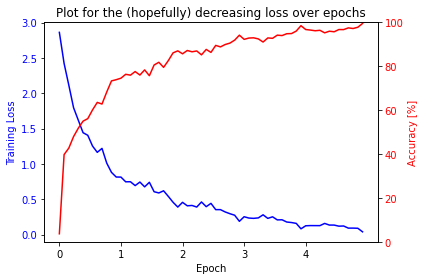

In [158]:
# training
model.fit(X_train, y_train)

#score
score = model.score(X_test, y_test)
print('\n')
print('====')
print(f'Accuracy for the model is {score}')
print('====')
print('\n')

#plot
model.plot()

### Baseline model

As a Baseline model, I decided to use the most Vanilla LTSM, which was implemented in the beginning.

In [142]:
model = Tagger(model_type = "LSTM",
               word_embedding_dim=32,
               hidden_dim=64, 
               vocabulary_size=len(token2idx),                             
               tagset_size=len(tag2idx)-1)   

Epoch 4: 100%|██████████| 13/13 [00:00<00:00, 21.29batch/s, accuracy=86.5, loss=0.438]




====
Accuracy for the Baseline model is 79.42803342356126
====




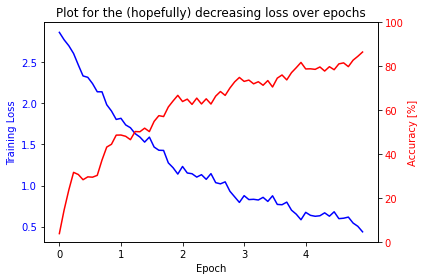

In [143]:
# training
model.fit(X_train, y_train)

#score
score = model.score(X_test, y_test)
print('\n')
print('====')
print(f'Accuracy for the Baseline model is {score}')
print('====')
print('\n')

#plot
model.plot()

## Analysis

**DATASETS:**

I decided to implement RNN models for 3 languages: Polish, English and Swedish. Since UD datasets are already split into training and test sets, I treated them as guidelines and decided to split the data the same way as creators. I also decided not to exclude short sentences.


**EXTENSIONS:**

As I mentioned above, I decided to implement:

•	GRU: as a multi-layer gated recurrent unit (GRU) RNN to an input sequence.

•	Bi-directional – when set to True, RNN becomes a bidirectional RNN.

•	Dropout – “introduces a Dropout layer on the outputs of each RNN layer except the last layer, with dropout probability equal to dropout.”

**THE BEST EXTENSIONS:**
Undoubtedly, making the model ‘bidirectional’ improves its performance. Models, which are not bidirectional, have the worst accuracy for every language. 
When it comes, to the dropout, the best value is ‘0’ or ‘0.001’. I did not notice any special rule behind it. It seems that implementing the dropout can worsen the model.
There is no huge difference between the accuracy of LSTM and GRU models. Swedish is the only language, which performed better on the GRU model. However, the difference is really small. 


**TUNING HYPERPARAMETERS:**

To find the best implementation, I decided to run nested loops. The goal of it, was to find the best hyperparameters. It is worth noticing, that there are few differences between the results of the hyperparameters tuning each time, the code is being run. Therefore “Final model” includes specified hyperparameters, which I got the last time. If you would like to run the ‘tuning hyperparameters’ (it can take a while!), remember that the values in the ‘Final model’ need to be changed. 

**BASELINE ACCURACY**

When we want to improve some systems, we need to compare the accuracy with the previous one. The baseline accuracy may be the performance of a simple system, in my case it is a basic LSTM model without any extensions.

**MODEL COMPLEXITY AND ACCURACY**

We can notice that my language models perform better on a higher dimensionality for the embedding and layers. When a language is morphologically complex, it requires higher dimensionality.

**ACCURACY – COMPARISON**


Surprisingly, all my models performed pretty similarly when it comes to accuracy. The best model for Polish achieved almost 91%, while the baseline model scored 88%. 
The final model for English achieved 86% of accuracy, while the baseline model scored 72%.
When it comes to Swedish, the best model scored 85%, while the baseline model scored 79%. 
We need to note that there is a difference in the length of the chosen datasets (Polish is the biggest one, English is the smallest one). In my opinion, since my datasets are imbalanced (when compared to each other), we cannot completely base on the scores, which were achieved.



